In [ ]:
!pip install --upgrade tfds-nightly
!pip install --upgrade tensorflow tensorflow-datasets

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.1/5.1 MB 24.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 113.6/113.6 kB 15.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 589.8/589.8 MB 1.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.1/5.1 MB 105.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.3/5.3 MB 85.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 81.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 93.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 74.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 311.2/311.2 kB 38.5 MB/s eta 0:00:00
  Attempting uninstall: ml-dtypes
    Found existing installation: ml-dtypes 0.2.0
    Uninstalling ml-dtypes-0.2.0:
      Successfully uninstalled ml-dtypes-0.2.0
  Attempting uninstall: h5py
    Found existing installation: h5py 3.9.0
    Uninstalling h5py-3.9.0:
      Succe

In [ ]:
import time
import tensorflow as tf
import tensorflow_datasets as tfds
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from tensorflow.keras.optimizers import Adam

# EMNIST 데이터셋 로드
ds_builder = tfds.builder("emnist/balanced")
ds_builder.download_and_prepare()
ds_info = ds_builder.info
dataset = ds_builder.as_data_source()

# Label Mapping
label_mapping = [
    '0', '1', '2', '3', '4', '5', '6', '7', '8', '9',
    'A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J',
    'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T',
    'U', 'V', 'W', 'X', 'Y', 'Z',
    'a', 'b', 'd', 'e', 'f', 'g', 'h', 'n', 'q', 'r', 't'
]

# 이미지 크기 조정 및 정규화
def preprocess(image, label):
    image = tf.image.resize(image, (224, 224))  # 이미지 크기를 224x224로 조정
    image = tf.image.grayscale_to_rgb(image)    # 그레이스케일 이미지를 RGB로 변환
    image = image / 255.0                       # 정규화
    return image, label

# 데이터 생성 (train, test)
X = []
y = []
for example in dataset['train']:
    X.append(example['image'])
    y.append(example['label'])

X_test = []
y_test = []
for example in dataset['test']:
    X_test.append(example['image'])
    y_test.append(example['label'])

X = np.array(X)
y = np.array(y)

X_test = np.array(X_test)
y_test = np.array(y_test)

# dataset 분할 (train:validation = 5:1), test dataset은 emnist dataset에 있는 것으로 사용
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=1/6, random_state=42)

# 데이터셋 구성 및 배치 설정
train_dataset = tf.data.Dataset.from_tensor_slices((X_train, y_train)).map(preprocess).shuffle(1000).batch(32)
valid_dataset = tf.data.Dataset.from_tensor_slices((X_valid, y_valid)).map(preprocess).batch(32)
test_dataset = tf.data.Dataset.from_tensor_slices((X_test, y_test)).map(preprocess).batch(32)

In [ ]:
from tensorflow.keras.layers import Conv2D, BatchNormalization, Activation, Dense, Flatten, Input, GlobalAveragePooling2D, Add, DepthwiseConv2D
from tensorflow.keras.models import Model

# EfficientNet 블록 정의
def mbconv_block(inputs, input_filters, output_filters, expand_ratio, stride):
    x = inputs
    if expand_ratio != 1:
        x = Conv2D(input_filters * expand_ratio, kernel_size=1, padding='same', use_bias=False)(x)
        x = BatchNormalization()(x)
        x = Activation('swish')(x)

    x = DepthwiseConv2D(kernel_size=3, strides=stride, padding='same', use_bias=False)(x)
    x = BatchNormalization()(x)
    x = Activation('swish')(x)

    x = Conv2D(output_filters, kernel_size=1, padding='same', use_bias=False)(x)
    x = BatchNormalization()(x)

    if stride == 1 and input_filters == output_filters:
        x = Add()([x, inputs])

    return x

def EfficientNetB0(input_shape=(224,224,3), num_classes=47):
    inputs = Input(shape=input_shape)

    x = Conv2D(32, kernel_size=3, strides=2, padding='same', use_bias=False)(inputs)
    x = BatchNormalization()(x)
    x = Activation('swish')(x)

    x = mbconv_block(x, input_filters=32, output_filters=16, expand_ratio=1, stride=1)
    x = mbconv_block(x, input_filters=16, output_filters=24, expand_ratio=6, stride=2)
    x = mbconv_block(x, input_filters=24, output_filters=40, expand_ratio=6, stride=2)
    x = mbconv_block(x, input_filters=40, output_filters=80, expand_ratio=6, stride=2)
    x = mbconv_block(x, input_filters=80, output_filters=112, expand_ratio=6, stride=1)
    x = mbconv_block(x, input_filters=112, output_filters=192, expand_ratio=6, stride=2)
    x = mbconv_block(x, input_filters=192, output_filters=320, expand_ratio=6, stride=1)

    x = Conv2D(1280, kernel_size=1, padding='same', use_bias=False)(x)
    x = BatchNormalization()(x)
    x = Activation('swish')(x)

    x = GlobalAveragePooling2D()(x)
    x = Dense(num_classes, activation='softmax')(x)

    model = Model(inputs, x)

    return model

model = EfficientNetB0(input_shape=(224,224,3), num_classes=47)
model.summary()


Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)           │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_15 (Conv2D)                   │ (None, 112, 112, 32)        │             864 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_22               │ (None, 112, 112, 32)        │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_15 (Activation)           │ (None, 112, 112, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ depthwise_conv2d_7 (DepthwiseConv2D) │ (None, 112, 112, 32)        │             288 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_23               │ (None, 112, 112, 32)        │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_16 (Activation)           │ (None, 112, 112, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_16 (Conv2D)                   │ (None, 112, 112, 16)        │             512 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_24               │ (None, 112, 112, 16)        │              64 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_17 (Conv2D)                   │ (None, 112, 112, 96)        │           1,536 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_25               │ (None, 112, 112, 96)        │             384 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_17 (Activation)           │ (None, 112, 112, 96)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ depthwise_conv2d_8 (DepthwiseConv2D) │ (None, 56, 56, 96)          │             864 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_26               │ (None, 56, 56, 96)          │             384 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_18 (Activation)           │ (None, 56, 56, 96)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_18 (Conv2D)                   │ (None, 56, 56, 24)          │           2,304 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_27               │ (None, 56, 56, 24)          │              96 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_19 (Conv2D)                   │ (None, 56, 56, 144)         │           3,456 │
├──────────────────────────────────────┼─────────────────────────────┼──────────────

 Total params: 1,455,439 (5.55 MB)

 Trainable params: 1,440,047 (5.49 MB)

 Non-trainable params: 15,392 (60.12 KB)

In [ ]:
# 모델 컴파일
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

start_time = time.time()   # 학습 시작 시간

# 모델 학습
history = model.fit(train_dataset, validation_data=valid_dataset, epochs=20)

training_time = time.time() - start_time   # 학습 시간 계산

Epoch 1/20
2938/2938 ━━━━━━━━━━━━━━━━━━━━ 268s 81ms/step - accuracy: 0.7216 - loss: 0.9177 - val_accuracy: 0.8282 - val_loss: 0.5050
Epoch 2/20
2938/2938 ━━━━━━━━━━━━━━━━━━━━ 228s 75ms/step - accuracy: 0.8626 - loss: 0.3880 - val_accuracy: 0.8477 - val_loss: 0.4436
Epoch 3/20
2938/2938 ━━━━━━━━━━━━━━━━━━━━ 261s 75ms/step - accuracy: 0.8769 - loss: 0.3438 - val_accuracy: 0.8763 - val_loss: 0.3489
Epoch 4/20
2938/2938 ━━━━━━━━━━━━━━━━━━━━ 221s 75ms/step - accuracy: 0.8864 - loss: 0.3133 - val_accuracy: 0.8713 - val_loss: 0.3660
Epoch 5/20
2938/2938 ━━━━━━━━━━━━━━━━━━━━ 220s 75ms/step - accuracy: 0.8906 - loss: 0.2947 - val_accuracy: 0.8834 - val_loss: 0.3262
Epoch 6/20
2938/2938 ━━━━━━━━━━━━━━━━━━━━ 223s 76ms/step - accuracy: 0.8976 - loss: 0.2754 - val_accuracy: 0.8781 - val_loss: 0.3459
Epoch 7/20
2938/2938 ━━━━━━━━━━━━━━━━━━━━ 220s 75ms/step - accuracy: 0.9016 - loss: 0.2601 - val_accuracy: 0.8853 - val_loss: 0.3349
Epoch 8/20
2938/2938 ━━━━━━━━━━━━━━━━━━━━ 264s 75ms/step - accuracy: 

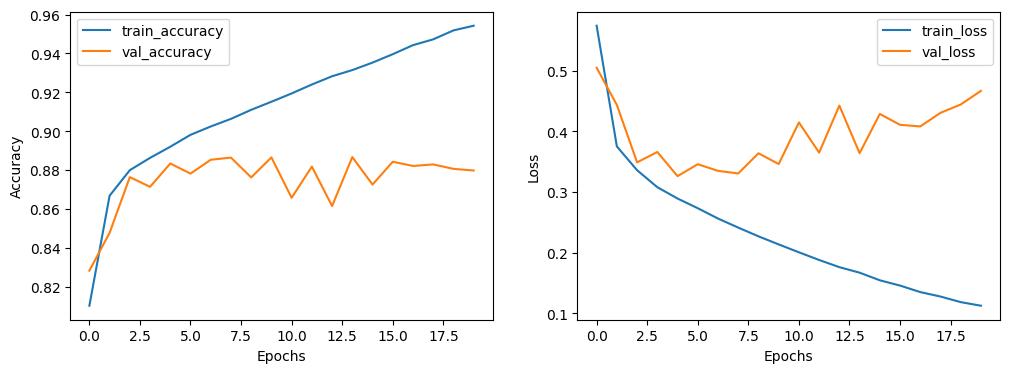

In [ ]:
# 학습 결과 시각화
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='train_accuracy')
plt.plot(history.history['val_accuracy'], label='val_accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='train_loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

In [ ]:
# 모델 평가

start_time = time.time()  # 추론 시작 시간
test_loss, test_accuracy = model.evaluate(test_dataset)
end_time = time.time()  # 추론 종료 시간
total_inference_time = end_time - start_time
average_inference_time = total_inference_time / len(X_test)

print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.4f}")
print(f"훈련시간 : {training_time/60:.2f} minutes.")
print(f"평균 추론 시간: {average_inference_time:.4f} seconds.")

588/588 ━━━━━━━━━━━━━━━━━━━━ 24s 41ms/step - accuracy: 0.8755 - loss: 0.4781
Test Loss: 0.4964, Test Accuracy: 0.8740
훈련시간 : 80.85 minutes.
평균 추론 시간: 0.0022 seconds.
